# Pylops - Non-stationary filters estimation

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryFilters1D`` and ``NonStationaryFilters2D`` operators to estimate non-stationary filters given an input and output signal. Note that the filters will be estimated on a coarser grid then the grid of signals and on-the-fly interpolation between the filters is performed as part of the operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *

## 1D filter estimation

In [2]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

Dop = FirstDerivative(101)
wav1, _, wav1c = ricker(t[:51], f0=20)
wav2 = ricker(t[:51], f0=50)[0]
wav2 = wav2 * (np.sum(np.abs(wav1)) / np.sum(np.abs(wav2)))

wav1 = Dop @ wav1
wav2 = Dop @ wav2

wavs = np.stack([wav1, wav2])

In [3]:
x = np.zeros(nt)
for ix in range(64, nt-64, 64):
    x[ix] = 1.

Cop = NonStationaryConvolve1D(dims=nt, hs=wavs, ih=(201, 401))
C1op = NonStationaryFilters1D(inp=x, hsize=wavs.shape[1],  ih=(201, 401))

In [4]:
y = Cop @ x
y1 = C1op @ wavs

np.allclose(y, y1)

True

In [5]:
dottest(C1op)

True

True

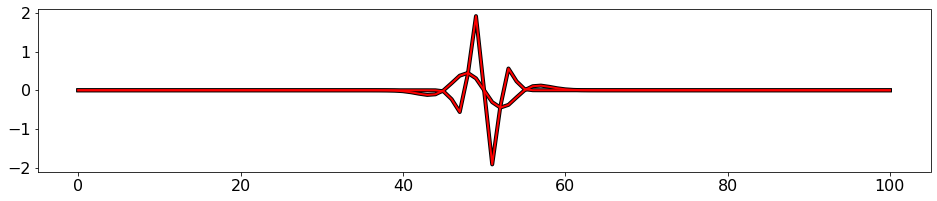

In [6]:
wavsinv = C1op.div(y, niter=200)
wavsinv = wavsinv.reshape(wavs.shape)

plt.figure(figsize=(16, 3))
plt.plot(wavs.T, 'k', lw=4)
plt.plot(wavsinv.T, 'r', lw=2)

np.allclose(wavs, wavsinv)

## 2D filter estimation

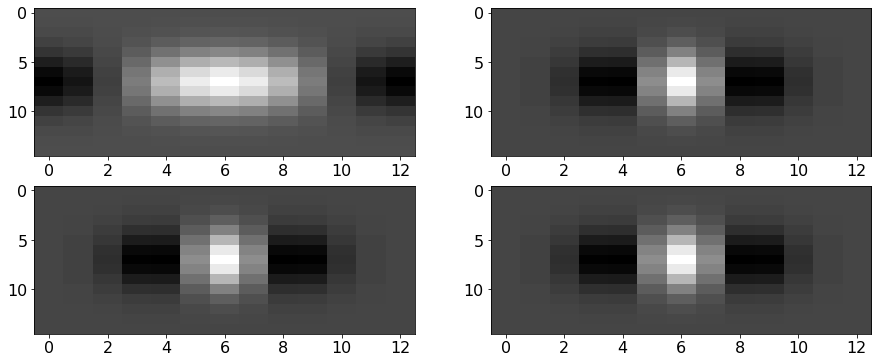

In [7]:
nx, nz = 101, 51
nt = 101
dt = 0.004

t = np.arange(nt)*dt
wav1a, _, wav1c = ricker(t[:7], f0=15)
wav1b = ricker(t[:7], f0=40)[0]
wav2 = sp.signal.windows.gaussian(15, 2.)

wav11 = np.outer(wav1a, wav2[np.newaxis]).T
wav12 = np.outer(wav1b, wav2[np.newaxis]).T
wav21 = np.outer(wav1b, wav2[np.newaxis]).T
wav22 = np.outer(wav1b, wav2[np.newaxis]).T
wavsize = wav11.shape

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(wav11, 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(wav12, 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(wav21, 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(wav22, 'gray')
axs[1,1].axis('tight');

In [8]:
hs = np.zeros((2, 2, *wavsize))
hs[0, 0] = wav11
hs[0, 1] = wav12
hs[1, 0] = wav21
hs[1, 1] = wav22

x = np.zeros((nx, nz))
x[:, 21] = 1.
x[:, 41] = -1.

Cop = NonStationaryConvolve2D(hs=hs, ihx=(21, 41), ihz=(21, 41), dims=(nx, nz), engine="numba")
C1op = NonStationaryFilters2D(inp=x, hshape=wavsize, ihx=(21, 41), ihz=(21, 41), engine="numba")

In [9]:
y = Cop @ x
y1 = C1op @ hs

np.allclose(y, y1)

True

In [10]:
dottest(Cop, verb=True)
dottest(C1op, verb=True)

Dot test passed, v^H(Opu)=-149.05496984163165 - u^H(Op^Hv)=-149.05496984163187
Dot test passed, v^H(Opu)=-38.96140278494913 - u^H(Op^Hv)=-38.96140278494934


True

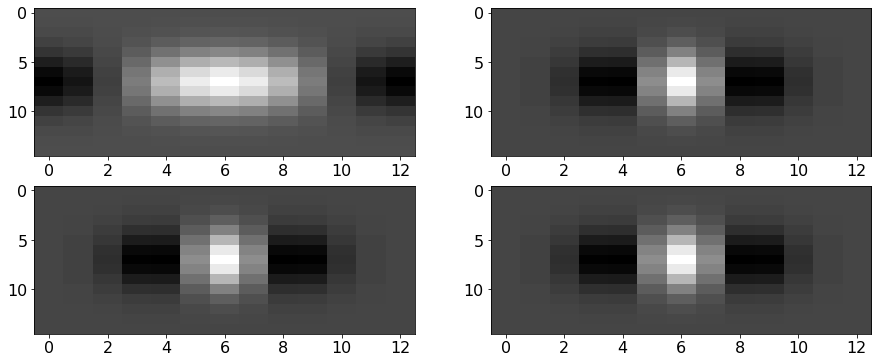

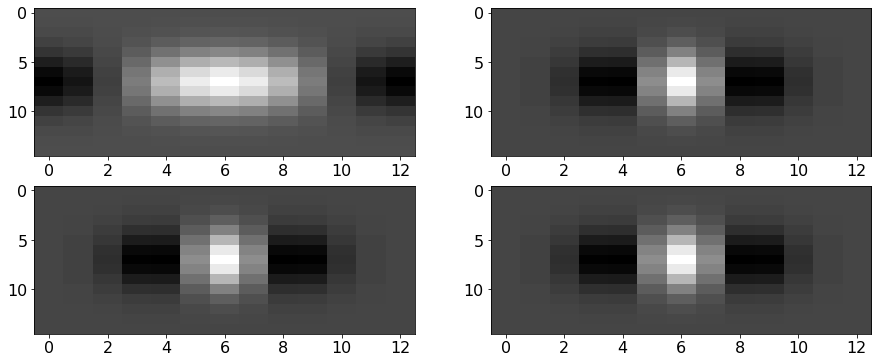

In [11]:
hsinv = C1op.div(y.ravel(), niter=200)
hsinv = hsinv.reshape(hs.shape)

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(hs[0,0], 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(hs[0,1], 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(hs[1,0], 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(hs[1,1], 'gray')
axs[1,1].axis('tight');

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(hsinv[0,0], 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(hsinv[0,1], 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(hsinv[1,0], 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(hsinv[1,1], 'gray')
axs[1,1].axis('tight');